In [1]:
pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-9xzoii_t
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-9xzoii_t
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=4d96e3805b4ff794f2f88100e02fc58f393737bb97387cd5cfa7742c4da98617
  Stored in directory: /tmp/pip-ephem-wheel-cache-uz00m9e0/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything


In [2]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [3]:
!mkdir -p weights

# Installing pre-trained SAM2 model
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth -P weights/
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -P weights/
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P weights/

--2024-12-16 05:15:11--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.70, 13.227.219.59, 13.227.219.33, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1249524607 (1.2G) [binary/octet-stream]
Saving to: ‘weights/sam_vit_l_0b3195.pth’

sam_vit_l_0b3195.pt 100%[===================>]   1.16G   240MB/s    in 9.7s    

2024-12-16 05:15:21 (123 MB/s) - ‘weights/sam_vit_l_0b3195.pth’ saved [1249524607/1249524607]

--2024-12-16 05:15:21--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.70, 13.227.219.59, 13.227.219.33, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-st

In [4]:
import torch
from segment_anything import SamPredictor, sam_model_registry
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np

# Load SAM-2 model
#sam_checkpoint = "/content/weights/sam_vit_l_0b3195.pth"
#sam_checkpoint = "/content/weights/sam_vit_b_01ec64.pth"
sam_checkpoint = "/content/weights/sam_vit_h_4b8939.pth"


#model_type = "vit_l"  # Mudeli tüüp, kui kasutan "vit_l"
#model_type = "vit_b"
model_type = "vit_h"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the model
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)
predictor = SamPredictor(sam)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [8]:
pip install Pillow

In [ ]:
import torch
from PIL import Image
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry


sam_checkpoint = "/content/weights/sam_vit_l_0b3195.pth"
sam = sam_model_registry["vit_l"](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)

def get_light_color(segment_mask, image_np):
    image_hsv = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)
    red_range = ((0, 50, 50), (10, 255, 255))
    yellow_range = ((20, 50, 50), (40, 255, 255))
    green_range = ((40, 50, 50), (90, 255, 255))
    segment_pixels = image_hsv[segment_mask == 1]

    def is_within_range(pixel, color_range):
        lower, upper = color_range
        return np.all(pixel >= lower) and np.all(pixel <= upper)

    color_found = None
    for pixel in segment_pixels:
        if is_within_range(pixel, red_range):
            color_found = "Red"
            break
        elif is_within_range(pixel, yellow_range):
            color_found = "Yellow"
            break
        elif is_within_range(pixel, green_range):
            color_found = "Green"
            break

    return color_found if color_found else "Traffic"

image_folder = '/content'
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
results = []


batch_size = 5
for i in range(0, len(image_files), batch_size):
    batch_files = image_files[i:i+batch_size]
    for image_file in batch_files:
        image_path = os.path.join(image_folder, image_file)
        image = Image.open(image_path).convert("RGB")
        image_np = np.array(image)

        # Downscale image to speed up processing (e.g., 50% reduction)
        image_resized = cv2.resize(image_np, (image_np.shape[1] // 2, image_np.shape[0] // 2))

        predictor.set_image(image_resized)
        masks, scores, logits = predictor.predict()

        for i, mask in enumerate(masks):
            light_color = get_light_color(mask, image_resized)
            print(f"Segment {i + 1} in {image_file} is {light_color} light.")
            results.append({"image_file": image_file, "segment": i + 1, "light_color": light_color})


df = pd.DataFrame(results)
df.to_csv("/content/detected_traffic_lights.csv", index=False)
print("Results saved to detected_traffic_lights.csv")


Processing image 041495.jpg
Masks shape: (3, 604, 960), Scores: [0.45197594 0.41488844 0.42347068]


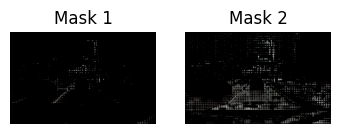

Mask 0 for image 041495.jpg is empty, skipping.
Mask 1 for image 041495.jpg has 5279 non-zero pixels.
Mask 2 for image 041495.jpg has 53393 non-zero pixels.


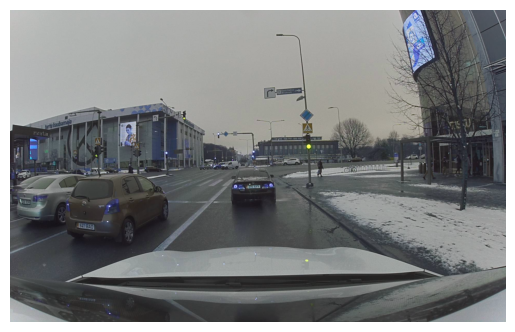

No annotations found for image 041495.jpg


KeyboardInterrupt: 

In [5]:
import torch
from PIL import Image
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry

# Load SAM model
sam_checkpoint = "/content/weights/sam_vit_h_4b8939.pth"
sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)

def get_light_color(segment_mask, image_np):
    image_hsv = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)
    red_range = ((0, 50, 50), (10, 255, 255))
    yellow_range = ((20, 50, 50), (40, 255, 255))
    green_range = ((40, 50, 50), (90, 255, 255))
    segment_pixels = image_hsv[segment_mask == 1]

    def is_within_range(pixel, color_range):
        lower, upper = color_range
        return np.all(pixel >= lower) and np.all(pixel <= upper)

    color_found = None
    for pixel in segment_pixels:
        if is_within_range(pixel, red_range):
            color_found = "Red"
            break
        elif is_within_range(pixel, yellow_range):
            color_found = "Yellow"
            break
        elif is_within_range(pixel, green_range):
            color_found = "Green"
            break

    return color_found if color_found else "Traffic Light"

def get_bounding_box(mask):
    """Get the bounding box from the segmentation mask"""
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        contour = max(contours, key=cv2.contourArea)  # Get the largest contour
        x, y, w, h = cv2.boundingRect(contour)
        return (x, y, x + w, y + h)
    return None

def convert_to_yolo_format(bbox, img_width, img_height):
    """Convert bounding box to YOLO format"""
    x_min, y_min, x_max, y_max = bbox
    center_x = (x_min + x_max) / 2 / img_width
    center_y = (y_min + y_max) / 2 / img_height
    width = (x_max - x_min) / img_width
    height = (y_max - y_min) / img_height
    return center_x, center_y, width, height

def is_traffic_light_shape(bbox, image_np):
    """Check if the bounding box contains a plausible traffic light shape"""
    # Check if the aspect ratio is similar to that of a traffic light (typically tall)
    x_min, y_min, x_max, y_max = bbox
    aspect_ratio = (y_max - y_min) / (x_max - x_min)
    if aspect_ratio > 2:  # Roughly matches a vertical traffic light shape
        return True
    return False

def visualize_masks(image, masks):
    """Visualize the masks on the image."""
    for i, mask in enumerate(masks):
        if np.sum(mask) > 0:
            # Create an image with the mask
            masked_image = image.copy()
            masked_image[mask == 0] = 0  # Mask out non-relevant parts
            plt.subplot(1, len(masks), i + 1)
            plt.imshow(masked_image)
            plt.title(f"Mask {i}")
            plt.axis('off')
    plt.show()

# Initialize
image_folder = '/content'
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
results = []

# Process images in batches
batch_size = 5
for i in range(0, len(image_files), batch_size):
    batch_files = image_files[i:i+batch_size]
    for image_file in batch_files:
        image_path = os.path.join(image_folder, image_file)
        image = Image.open(image_path).convert("RGB")
        image_np = np.array(image)
        image_height, image_width = image_np.shape[:2]

        # Downscale image to speed up processing (e.g., 50% reduction)
        image_resized = cv2.resize(image_np, (image_np.shape[1] // 2, image_np.shape[0] // 2))

        predictor.set_image(image_resized)
        masks, scores, logits = predictor.predict()

        # Debug: Check the output of masks and scores
        print(f"Processing image {image_file}")
        print(f"Masks shape: {masks.shape}, Scores: {scores}")

        # Visualize the masks to understand what the model detected
        visualize_masks(image_resized, masks)

        # Initialize YOLO annotations for the current image
        yolo_annotations = []

        # Create a copy of the original image to display bounding boxes
        image_with_bboxes = image_resized.copy()

        for i, mask in enumerate(masks):
            # Check if a mask is valid (non-zero)
            if np.sum(mask) == 0:
                print(f"Mask {i} for image {image_file} is empty, skipping.")
                continue

            # Check the size of the mask
            mask_size = np.sum(mask)
            print(f"Mask {i} for image {image_file} has {mask_size} non-zero pixels.")

            # Get bounding box from the mask
            bbox = get_bounding_box(mask)
            if bbox and is_traffic_light_shape(bbox, image_resized):
                # Convert the bounding box to YOLO format
                center_x, center_y, width, height = convert_to_yolo_format(bbox, image_width, image_height)

                # Classify light color
                light_color = get_light_color(mask, image_resized)

                # Map light color to YOLO class (optional: extend for more colors)
                if light_color == "Red":
                    class_id = 0
                elif light_color == "Yellow":
                    class_id = 1
                elif light_color == "Green":
                    class_id = 2
                else:
                    class_id = 3  # For "Traffic Light" or unknown colors

                # Save YOLO annotation
                yolo_annotations.append(f"{class_id} {center_x} {center_y} {width} {height}")

                # Draw the bounding box on the image
                cv2.rectangle(image_with_bboxes, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
                cv2.putText(image_with_bboxes, light_color, (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Show the image with bounding boxes and labels
        plt.imshow(cv2.cvtColor(image_with_bboxes, cv2.COLOR_BGR2RGB))
        plt.axis('off')  # Hide axis for better visualization
        plt.show()

        # Print out all annotations for the current image
        if yolo_annotations:
            print(f"Annotations for image {image_file}:")
            for annotation in yolo_annotations:
                print(f"  {annotation}")
        else:
            print(f"No annotations found for image {image_file}")

        # Save YOLO annotations in text file
        if yolo_annotations:
            txt_file_path = os.path.splitext(image_path)[0] + ".txt"
            with open(txt_file_path, 'w') as f:
                for annotation in yolo_annotations:
                    f.write(f"{annotation}\n")

        # Add result data for later use (optional)
        results.append({"image_file": image_file, "annotations": yolo_annotations})

# Save the results to CSV if needed (optional)
df = pd.DataFrame(results)
df.to_csv("/content/detected_traffic_lights.csv", index=False)
print("Results saved to detected_traffic_lights.csv")





Detected candidate points: []


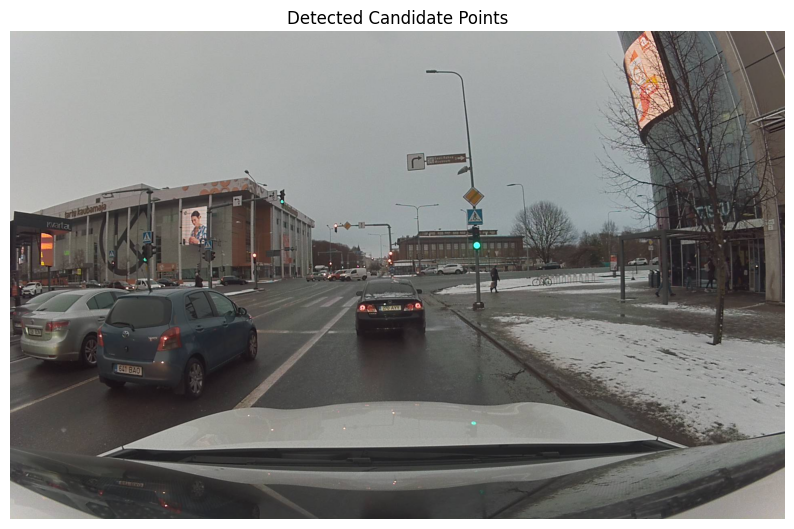

In [8]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry
from google.colab.patches import cv2_imshow

# ------------------------
# Load SAM Model
# ------------------------
sam_checkpoint = "weights/sam_vit_h_4b8939.pth"  # Path to SAM checkpoint
model_type = "vit_h"
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)
predictor = SamPredictor(sam)

# ------------------------
# Load and Preprocess Image
# ------------------------
image_path = "/content/041495.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for SAM
predictor.set_image(image_rgb)

# ------------------------
# Function: Automatically Detect Candidate Points for Traffic Lights
# ------------------------
import cv2
import numpy as np

def detect_candidate_points(image):
    """
    Detect traffic lights based on shape (tall and narrow) and black color.
    Only includes objects that are black, have contours, and the right shape.
    """
    candidate_points = []
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 1: Define a range for black (low value in the V channel)
    black_lower, black_upper = (0, 0, 0), (180, 255, 50)  # Low brightness for black regions

    # Create a mask for black regions
    mask_black = cv2.inRange(hsv, black_lower, black_upper)

    # Step 2: Find contours from the black mask
    kernel = np.ones((3, 3), np.uint8)
    cleaned_mask = cv2.morphologyEx(mask_black, cv2.MORPH_OPEN, kernel)
    contours, _ = cv2.findContours(cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        area = cv2.contourArea(contour)
        if area < 100 or area > 10000:
            continue  # Ignore too small or too large regions

        # Bounding box and aspect ratio filtering (Traffic light shape is tall and narrow)
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = h / w
        if not (1.5 < aspect_ratio < 6):
            continue  # Skip if not tall and narrow like traffic lights

        # Candidate point is the center of the bounding box
        center_x, center_y = x + w // 2, y + h // 2
        candidate_points.append((center_x, center_y))

        # Draw bounding box for debugging
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return candidate_points, image


# ------------------------
# Detect Candidate Points and Display Results
# ------------------------
candidate_points, visualization_image = detect_candidate_points(image)
print(f"Detected candidate points: {candidate_points}")

# Display the image with detected candidate points
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(visualization_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Candidate Points")
plt.axis("off")
plt.show()

# ------------------------
# Function: Segment Image with SAM using Candidate Points
# ------------------------
def segment_with_point_prompts(image, predictor, points):
    """Generate masks using SAM for given candidate points."""
    masks = []
    for point in points:
        input_point = np.array([point])
        input_label = np.array([1])
        mask, _, _ = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=False
        )
        masks.append(mask)
    return masks

# ------------------------
# Generate Masks with SAM
# ------------------------
masks = segment_with_point_prompts(image_rgb, predictor, candidate_points)

# ------------------------
# Display Results: Filter and Visualize Masks
# ------------------------
for i, mask in enumerate(masks):
    mask_area = np.sum(mask)
    if mask_area < 100 or mask_area > 50000:  # Filter out too small or large masks
        print(f"Mask {i} skipped: Size out of range.")
        continue

    # Overlay mask on the image
    overlay = image_rgb.copy()
    overlay[mask[0]] = [0, 255, 0]  # Green overlay for mask

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.title(f"Mask {i} Overlay")
    plt.axis("off")
    plt.show()

